In [93]:
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.decomposition import NMF
from scipy.spatial.distance import cosine

from sklearn.decomposition import NMF
import librosa.display
from fastdtw import fastdtw


In [94]:
audio_1, sr_1 = librosa.load("Martinho_da_Vila_Mulheres.mp3", sr=None)  
#audio_1, sr_1 = librosa.load("Ramstein_Du_Hast.mp3", sr=None)
audio_2, sr_2 = librosa.load('Million_Years_Ago.mp3', sr=None)
#audio_2, sr_2 = librosa.load('Mulheres_Zeca_Pagodinho.mp3', sr=None)
#name_1 = "Du Hast - Ramstein"
name_1 = "Mulheres - Martinho da Vila"
name_2 = "Million Years Ago - Adele"
#name_2 = 'Mulheres - Zeca Pagodinho'

## MFCC (Mel-frequency cepstral coefficients):

https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

Curiosidade: Sistemas como assistentes virtuais (e.g., Alexa, Siri) usam MFCCs como entrada para modelos que reconhecem comandos de voz.

In [95]:
mfcc_1 = librosa.feature.mfcc(y=audio_1, sr=sr_1)
mfcc_2 = librosa.feature.mfcc(y=audio_2, sr=sr_2)

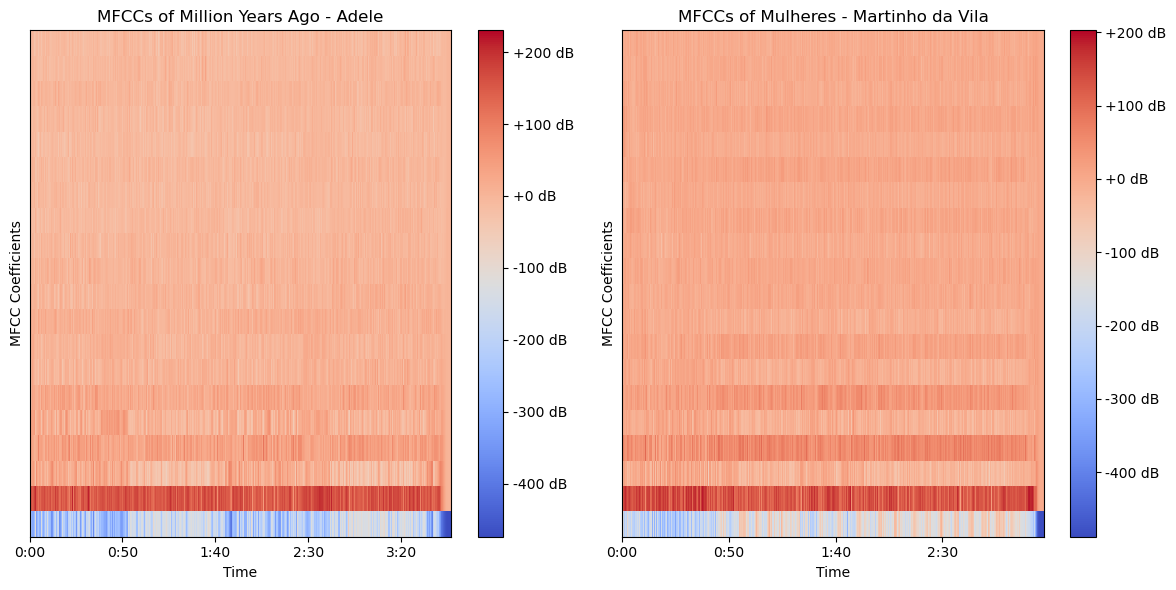

MFCC shape: (20, 18518)
intervals_s shape: (18518,)
Intervals for MFCC calculation [ms]: 10.666666666666666 ms


In [96]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cax1 = librosa.display.specshow(mfcc_2, x_axis='time', sr=sr_2, ax=ax[0])
ax[0].set_title(f"MFCCs of {name_2}")
ax[0].set_ylabel('MFCC Coefficients')

cax2 = librosa.display.specshow(mfcc_1, x_axis='time', sr=sr_1, ax=ax[1])
ax[1].set_title(f"MFCCs of {name_1}")
ax[1].set_ylabel('MFCC Coefficients')

fig.colorbar(cax1, ax=ax[0], format="%+2.0f dB")
fig.colorbar(cax2, ax=ax[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()

hop_length=512
audio_length_1 = len(audio_1) / sr_1 # in seconds
step = hop_length / sr_1 # in seconds
intervals_s = np.arange(start=0, stop=audio_length_1, step=step)

print(f'MFCC shape: {mfcc_1.shape}')
print(f'intervals_s shape: {intervals_s.shape}')
print(f'Intervals for MFCC calculation [ms]: {(intervals_s[1]-intervals_s[0])*1000} ms')

In [97]:
# Distância euclidiana entre os MFCCs
distance = euclidean(mfcc_1.mean(axis=1), mfcc_2.mean(axis=1))
print(f"Distância Euclidiana entre os MFCCs: {distance}")
# Similaridade do cosseno entre os MFCCs
similarity = 1 - cosine(mfcc_1.mean(axis=1), mfcc_2.mean(axis=1))
print(f"Similaridade do Cosseno entre os MFCCs: {similarity}")

Distância Euclidiana entre os MFCCs: 69.96451568603516
Similaridade do Cosseno entre os MFCCs: 0.9778221845626831


#### Por que usar a escala Mel em arquivos de áudio?

O ouvido humano não percebe frequências de maneira linear. Somos mais sensíveis a frequências baixas. Podemos diferenciar pequenas mudanças em frequências menores (por exemplo, entre 200 Hz e 300 Hz). Por outro lado, somos menos sensíveis a frequências altas: A diferença entre 5000 Hz e 5100 Hz é muito menos perceptível para nossos ouvidos.

A escala Mel foi projetada para capturar essa característica não linear da percepção humana de frequência.

A relação entre a frequência em Hertz 

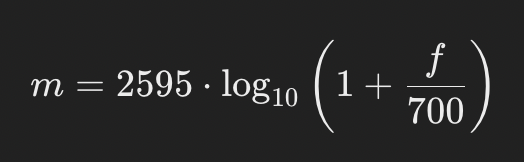


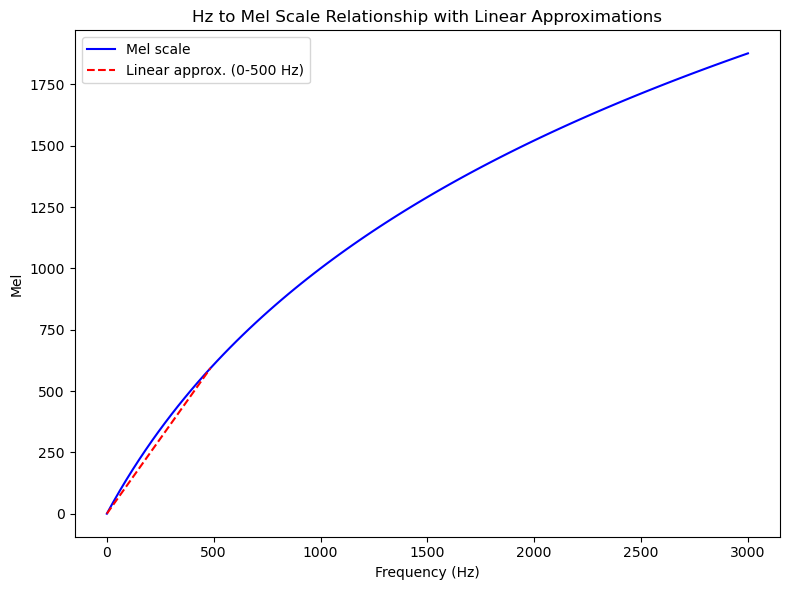

In [98]:


# Define the Hz range and Mel scale conversion
f_hz = np.linspace(0, 3000, 100)
mel = 2595 * np.log10(1 + f_hz / 700)

low_freq_range = f_hz[f_hz <= 500]
low_freq_approx = 2595 * np.log10(1 + low_freq_range / 700)  # Mel values
low_slope = (low_freq_approx[-1] - low_freq_approx[0]) / (low_freq_range[-1] - low_freq_range[0])
low_line = low_slope * (f_hz - low_freq_range[0]) + low_freq_approx[0]


plt.figure(figsize=(8, 6))
plt.plot(f_hz, mel, label="Mel scale", color='blue')
plt.plot(f_hz[f_hz <= 500], low_line[f_hz <= 500], '--', label="Linear approx. (0-500 Hz)", color='red')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mel")
plt.title("Hz to Mel Scale Relationship with Linear Approximations")
plt.legend()
plt.tight_layout()
plt.show()


## Espectrogramas

Outra abordagem seria comparar os espectrogramas dos arquivos, que representam a distribuição das frequências ao longo do tempo.

/var/folders/9h/xqpjsqgd0sg75x4tr9z3dqhh0000gn/T/ipykernel_22026/3851702176.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D1 = librosa.amplitude_to_db(librosa.stft(audio_1), ref=np.max)
/var/folders/9h/xqpjsqgd0sg75x4tr9z3dqhh0000gn/T/ipykernel_22026/3851702176.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D2 = librosa.amplitude_to_db(librosa.stft(audio_2), ref=np.max)


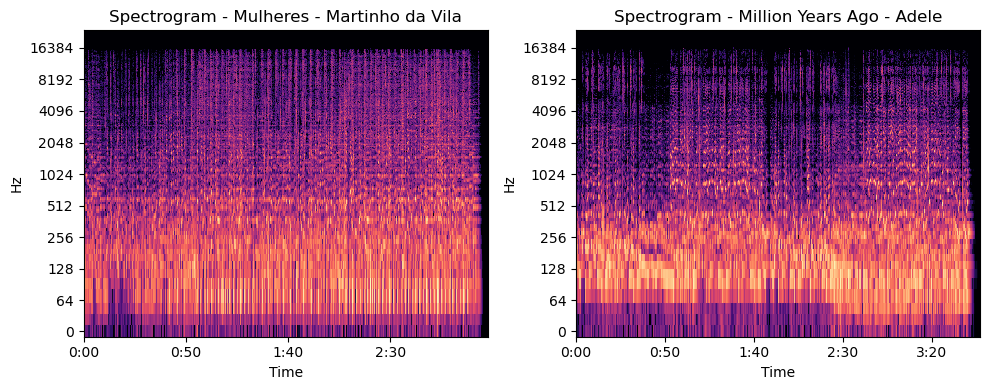

In [99]:
D1 = librosa.amplitude_to_db(librosa.stft(audio_1), ref=np.max)
D2 = librosa.amplitude_to_db(librosa.stft(audio_2), ref=np.max)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(D1, sr=sr_1, x_axis='time', y_axis='log')
plt.title(f"Spectrogram - {name_1}")

plt.subplot(1, 2, 2)
librosa.display.specshow(D2, sr=sr_2, x_axis='time', y_axis='log')
plt.title(f"Spectrogram - {name_2}")

plt.tight_layout()
plt.show()

Não existe um limite universal fixo de cosine similarity para determinar plágio em músicas com base em MFCCs ou outros recursos de áudio. A determinação de plágio musical é altamente contextual e frequentemente requer uma combinação de análise técnica, artística e legal. 

Pequenas diferenças em ritmo, tempo ou tonalidade podem reduzir artificialmente a similaridade, mesmo em casos de plágio.

Harmonia, melodia e ritmo: Plágio não é determinado apenas por semelhança sonora geral, mas também por similaridade específica nos componentes musicais.

## Chroma Features

As Chroma Features representam as energias de diferentes notas (C, D, E, etc.) em uma escala musical, ignorando oitavas. Elas podem ser úteis para comparar a harmonia (combinações de notas tocadas simultaneamente).

https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html

In [100]:
chroma1 = librosa.feature.chroma_stft(y=audio_1, sr=sr_1)
chroma2 = librosa.feature.chroma_stft(y=audio_2, sr=sr_2)

# Calcular similaridade por cosseno entre as médias das Chroma Features
mean_chroma1 = np.mean(chroma1, axis=1)
mean_chroma2 = np.mean(chroma2, axis=1)

chroma_similarity = 1 - cosine(mean_chroma1, mean_chroma2)

print(f"Similaridade de Chroma Features (Cosseno): {chroma_similarity}")

Similaridade de Chroma Features (Cosseno): 0.9788281917572021


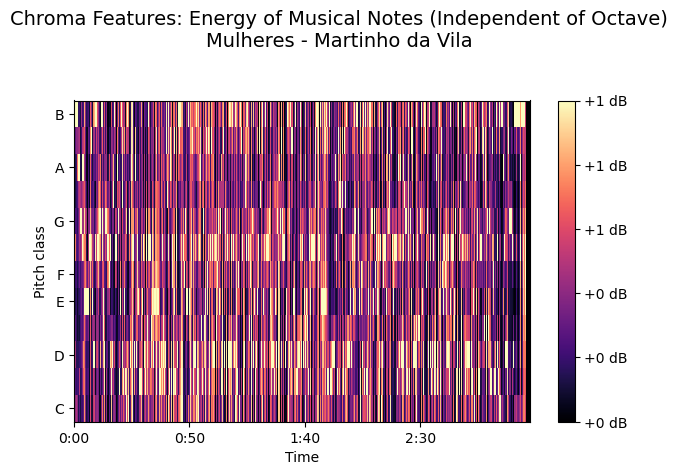

In [101]:
fig, ax = plt.subplots(nrows=1)
fig.suptitle(f"Chroma Features: Energy of Musical Notes (Independent of Octave)\n{name_1}", fontsize=14)
img = librosa.display.specshow(chroma1, sr=sr_1, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()


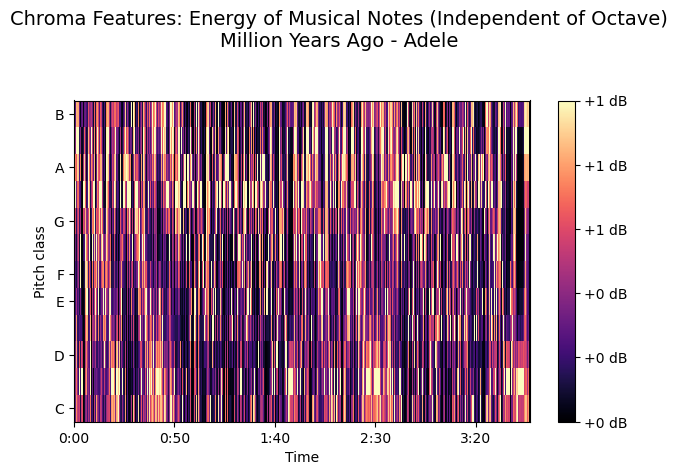

In [102]:
fig, ax = plt.subplots(nrows=1)
fig.suptitle(f"Chroma Features: Energy of Musical Notes (Independent of Octave)\n{name_2}", fontsize=14)
img = librosa.display.specshow(chroma2, sr=sr_2, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

## Extração de Melodia Utilizando Multi-Pitch Detection (NMF)

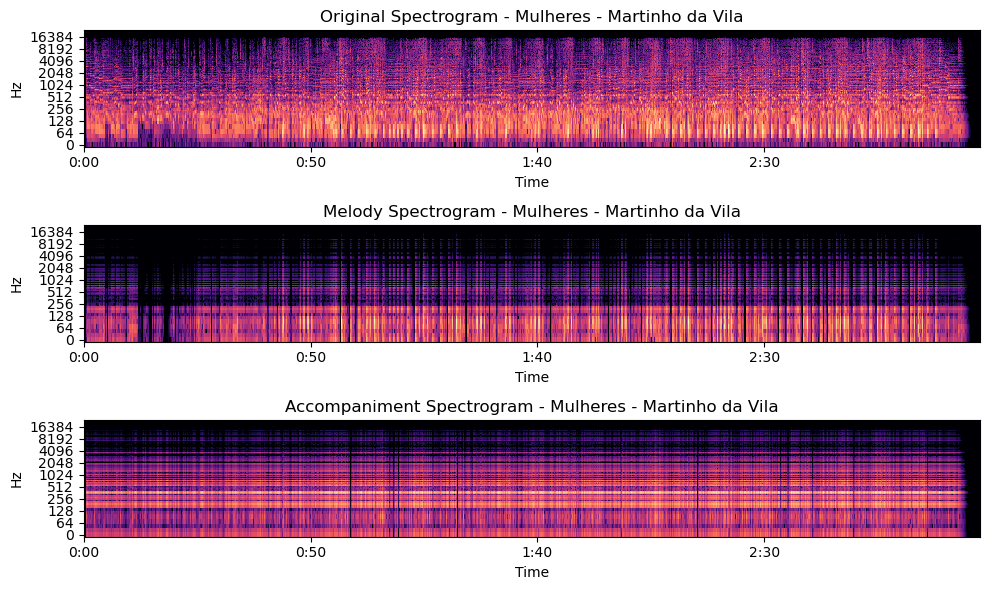

In [103]:
# Short-time Fourier transform (STFT)
D = librosa.stft(audio_1, )

# Convert to magnitude 
S = np.abs(D)

# Apply Non-negative Matrix Factorization (NMF) to separate components
n_components = 2  # We'll extract 2 components: melody and accompaniment
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(S.T)
H = model.components_

# Reconstruct the separated components
melody = np.dot(W[:, 0:1], H[0:1, :])
accompaniment = np.dot(W[:, 1:2], H[1:2, :])

# Inverse STFT to get time-domain signals
melody_audio = librosa.istft(melody.T)
accompaniment_audio = librosa.istft(accompaniment.T)

# Plot the original, melody, and accompaniment spectrograms
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

# Original spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr = sr_1, x_axis='time', y_axis='log', ax=axs[0])
axs[0].set_title(f"Original Spectrogram - {name_1}")

# Melody spectrogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(melody_audio))), sr = sr_1, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_title(f"Melody Spectrogram - {name_1}")

# Accompaniment spectrogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(accompaniment_audio))), sr = sr_1, x_axis='time', y_axis='log', ax=axs[2])
axs[2].set_title(f"Accompaniment Spectrogram - {name_1}")

plt.tight_layout()
plt.show()

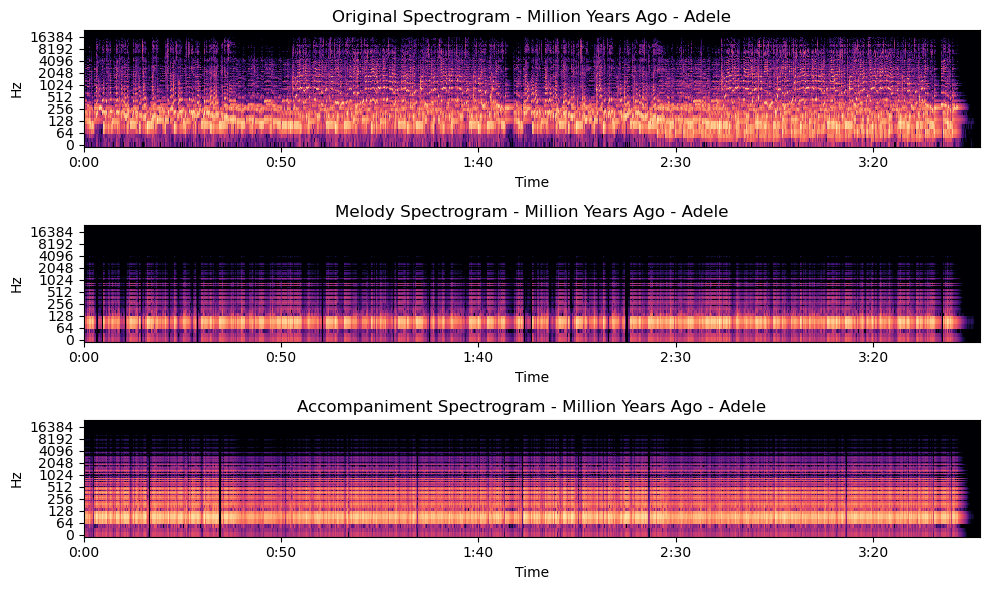

In [104]:
# Short-time Fourier transform (STFT)
D = librosa.stft(audio_2)

# Convert to magnitude spectrogram (log scale)
S = np.abs(D)

# Apply Non-negative Matrix Factorization (NMF) to separate components
n_components = 2  # We'll extract 2 components: melody and accompaniment
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(S.T)
H = model.components_

# Reconstruct the separated components
melody = np.dot(W[:, 0:1], H[0:1, :])
accompaniment = np.dot(W[:, 1:2], H[1:2, :])

# Inverse STFT to get time-domain signals
melody_audio = librosa.istft(melody.T)
accompaniment_audio = librosa.istft(accompaniment.T)

# Plot the original, melody, and accompaniment spectrograms
fig, axs = plt.subplots(3, 1, figsize=(10, 6))

# Original spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr = sr_2, x_axis='time', y_axis='log', ax=axs[0])
axs[0].set_title(f"Original Spectrogram - {name_2}")

# Melody spectrogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(melody_audio))), sr = sr_2, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_title(f"Melody Spectrogram - {name_2}")

# Accompaniment spectrogram
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(accompaniment_audio))), sr = sr_2, x_axis='time', y_axis='log', ax=axs[2])
axs[2].set_title(f"Accompaniment Spectrogram - {name_2}")

plt.tight_layout()
plt.show()

## Extração de Features de Ritmo 

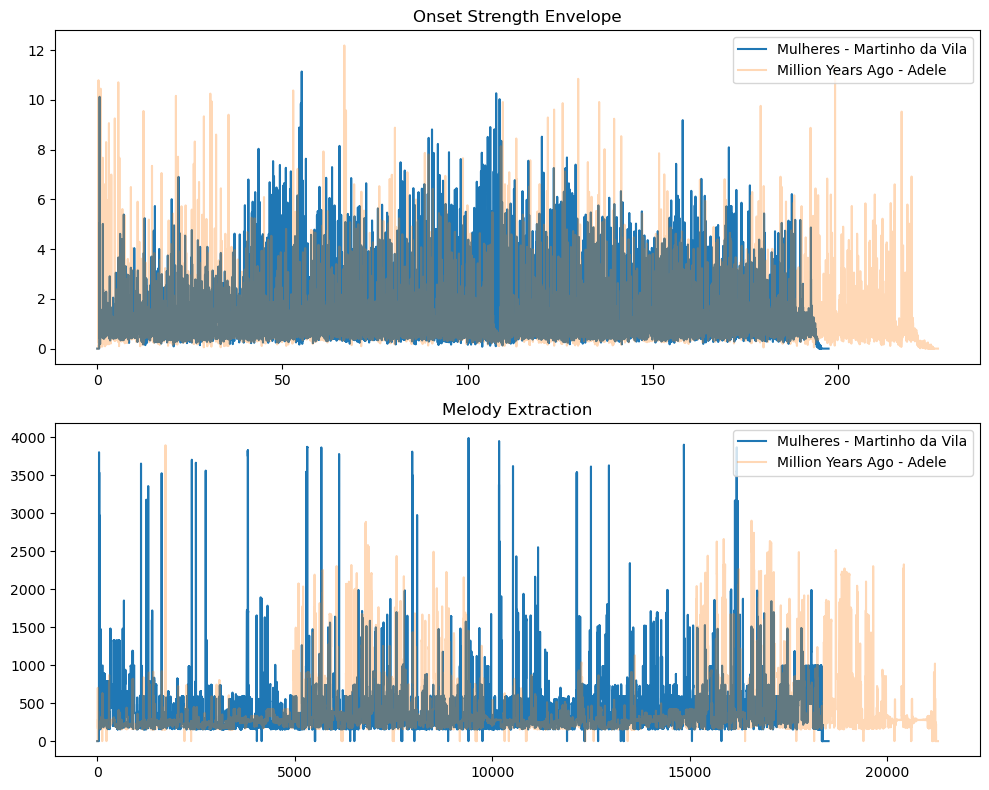

Tempo of 'Mulheres - Martinho da Vila': [130.81395349] BPM
Tempo of 'Million Years Ago - Adele': [106.13207547] BPM
DTW Distance (Melody): 5203006.181427002
DTW Distance (Onsets): 1407.4026666666664


In [105]:
# Onset Detection
def detect_onsets(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    return onset_times, onset_env

onset_times_1, onset_env_1 = detect_onsets(audio_1, sr_1)
onset_times_2, onset_env_2 = detect_onsets(audio_2, sr_2)

# Rhythm Analysis using Autocorrelation
def estimate_tempo(onset_env, sr):
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    return tempo

tempo_1 = estimate_tempo(onset_env_1, sr_1)
tempo_2 = estimate_tempo(onset_env_2, sr_2)

# Melody Extraction using Pitch Tracking
def extract_melody(y, sr):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    melody = []
    for i in range(pitches.shape[1]):
        if magnitudes[:, i].max() > 0:  # Check if there is a prominent pitch
            index = np.argmax(magnitudes[:, i])  # Get the pitch with the highest magnitude
            melody.append(pitches[index, i])
        else:
            melody.append(0)  # Append 0 if no pitch is detected
    return np.array(melody)

melody_1 = extract_melody(audio_1, sr_1)
melody_2 = extract_melody(audio_2, sr_2)

# Align Melodies and Rhythms using Dynamic Time Warping (DTW)
def compute_dtw(sequence_1, sequence_2):
    # Ensure both sequences are 1D
    sequence_1 = np.array(sequence_1).flatten().reshape(-1,1)
    sequence_2 = np.array(sequence_2).flatten().reshape(-1,1)
    
    # Validate that sequences are not empty
    if len(sequence_1) == 0 or len(sequence_2) == 0:
        raise ValueError("One or both sequences are empty after preprocessing.")
    
    # Perform DTW calculation
    distance, path = fastdtw(sequence_1, sequence_2, dist=euclidean)
    return distance, path


dtw_melody_distance, melody_path = compute_dtw(melody_1, melody_2)
dtw_onset_distance, onset_path = compute_dtw(onset_times_1, onset_times_2)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot Onset Strengths
ax[0].plot(librosa.times_like(onset_env_1, sr=sr_1), onset_env_1, label=f"{name_1}")
ax[0].plot(librosa.times_like(onset_env_2, sr=sr_2), onset_env_2, label=f"{name_2}", alpha=0.3)
ax[0].set_title("Onset Strength Envelope")
ax[0].legend()

# Plot Melody Comparison
ax[1].plot(melody_1, label=f"{name_1}")
ax[1].plot(melody_2, label=f"{name_2}", alpha=0.3)
ax[1].set_title("Melody Extraction")
ax[1].legend()

plt.tight_layout()
plt.show()

# Results
print(f"Tempo of '{name_1}':", tempo_1, "BPM")
print(f"Tempo of '{name_2}':", tempo_2, "BPM")
print("DTW Distance (Melody):", dtw_melody_distance)
print("DTW Distance (Onsets):", dtw_onset_distance)
